In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator

## The Proposed Problem

Use Girvan-Newman method to
1. Evaluate and promote the criticality of bridges in a given transportation network that is overshadowed by network redundancy
2. Reduce the number of links in network or the size of the network to be closed to the number of bridges.

There are 4 main steps:
1. STEP 1: Define Link Weight
2. STEP 2: Clustering Girvan Newman
3. STEP 3: Adjust Bridge Dominance
4. STEP 4: Big Node and Super Link


#### NOTE:
In this work, the constructions of new big node and deletion of link (Step 3 and Step 4)  are manually conceptualized. Hence, there is no code or algorithm to it. The improvement is needed to make a direct algorithm to evaluate and reconstruct new network for Step 3 and Step 4.

### ALGORITHM TRIAL ON HIGH REDUNDANCY
#### 1. Creating the graph

C:\Users\denis\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


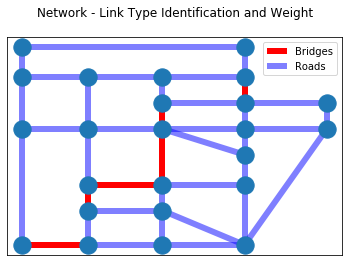

In [2]:
#Assumption: In this clustering algorithm, the graph is considered as undirected graph
nodes = pd.read_csv('SiouxFalls_node.csv')
nodes_data = nodes.set_index('node').to_dict('index').items()
edges = pd.read_csv('SiouxFalls_Liu2009_Undirected_edge.csv')

G = nx.from_pandas_edgelist(edges, 'u', 'v', ['cap','cost', 'bridge', 'delay', 'ebet', 'w1', 'w2', 'w3', 'w4'], create_using=nx.Graph())
G.add_node(1, loc=(50000, 510000))
G.add_node(2, loc=(320000,510000))
G.add_node(3, loc=(50000,440000))
G.add_node(4, loc=(130000,440000))
G.add_node(5, loc=(220000,440000))
G.add_node(6, loc=(320000,440000))
G.add_node(7, loc=(420000,380000))
G.add_node(8, loc=(320000,380000))
G.add_node(9, loc=(220000,380000))
G.add_node(10, loc=(220000,320000))
G.add_node(11, loc=(130000,320000))
G.add_node(12, loc=(50000,320000))
G.add_node(13, loc=(50000,50000))
G.add_node(14, loc=(130000,190000))
G.add_node(15, loc=(220000,190000))
G.add_node(16, loc=(320000,320000))
G.add_node(17, loc=(320000,260000))
G.add_node(18, loc=(420000,320000))
G.add_node(19, loc=(320000,190000))
G.add_node(20, loc=(320000,50000))
G.add_node(21, loc=(220000,50000))
G.add_node(22, loc=(220000,130000))
G.add_node(23, loc=(130000,130000))
G.add_node(24, loc=(130000,50000))

# Attributes
loc = nx.get_node_attributes(G, 'loc')
delay = nx.get_edge_attributes(G, 'delay')
cap = nx.get_edge_attributes(G, 'cap')
cost = nx.get_edge_attributes(G, 'cost')
w1 = nx.get_edge_attributes(G, 'w1')
w2 = nx.get_edge_attributes(G, 'w2')
w3 = nx.get_edge_attributes(G, 'w3')
w4 = nx.get_edge_attributes(G, 'w4')
types = nx.get_edge_attributes(G,'bridge')
edgelist_type=list(G.edges(data='bridge'))
bridge= [(u, v) for (u, v, d) in edgelist_type if d == 1]
link_b = [(u, v) for (u, v, d) in G.edges(data=True) if d['bridge'] == 1]
link_c = [(u, v) for (u, v, d) in G.edges(data=True) if d['bridge'] == 0]

# Plotting
nx.draw_networkx_nodes(G, loc)
nx.draw_networkx_edges(G, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
nx.draw_networkx_edges(G, loc, edgelist=link_c, width=6, alpha=0.5, edge_color='b', label='Roads')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=delay)
plt.title('Network - Link Type Identification and Weight\n')
plt.legend(loc='best')
plt.savefig('test2.png', dpi=500)
plt.show()

#### STEP 1 - Edges Betweenness of Original Network

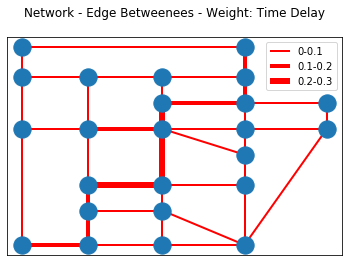

In [3]:
ebet=nx.edge_betweenness_centrality(G, normalized=True, weight='w1')

# Update Network Data
edgelist=list(G.edges())
i=0
for (u, v, d) in G.edges(data=True):
    d['ebet'] = ebet.get(edgelist[i])
    i+=1
    
# Attribute
edgelist_ebet=list(G.edges(data='ebet'))
ebetlist = [d for u,v,d in edgelist_ebet]
list_1 = [(u, v) for (u, v, d) in edgelist_ebet if d < 0.1]
list_2 = [(u, v) for (u, v, d) in edgelist_ebet if d >=0.1 and d < 0.2]
list_3 = [(u, v) for (u, v, d) in edgelist_ebet if d >=0.2 and d < 0.3]
list_4 = [(u, v) for (u, v, d) in edgelist_ebet if d >=0.3 ]

# Plotting
nx.draw_networkx_nodes(G, loc)
nx.draw_networkx_edges(G, loc, edgelist=list_1, width=2, edge_color='r', label='0-0.1')
nx.draw_networkx_edges(G, loc, edgelist=list_2, width=4, edge_color='r', label='0.1-0.2')
nx.draw_networkx_edges(G, loc, edgelist=list_3, width=6, edge_color='r', label='0.2-0.3')
nx.draw_networkx_edges(G, loc, edgelist=list_4, width=8, edge_color='r', label='>=0.3')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=types)
plt.title('Network - Edge Betweenees - Weight: Time Delay\n')
plt.legend(loc='best')
plt.savefig('test3.png', dpi=500)
plt.show()

#### STEP 2 - Modified Girvan-Newman Algorithm

In [5]:
#ALMOST>>>>
G_clustered = G
edgelist_deleted=[] #detect every important link
x = sorted(nx.connected_components(G), key=len, reverse=True)
k = 0
remaining_bridge = set(bridge) - set(edgelist_deleted)

#For every k component in set x do this:
for k in range(100):
    if k <= 100:
        G1 = G.subgraph(x[0]) # 1. Create subgraph of component k in set x
        SG_edgelist=list(G1.edges(data=True))
        SG_edgelistonly=list(G1.edges())
        SG_nodelist=list(G1.nodes(data=True))
        G1 = nx.Graph()
        G1.add_nodes_from(SG_nodelist)
        G1.add_edges_from(SG_edgelist)
        if any((u,v) in bridge for (u,v) in SG_edgelistonly): # 2. If at least one remaining bridge in this component, do this: #if len(remaining_bridge) > 0: - apakah harus dipake?? sementara pakai check u,v dulu ajah #if any((u,v) in bridge for (u,v) in SG_edgelistonly):
            while nx.is_connected(G1): #Girvan-Newman
                ebet=nx.edge_betweenness_centrality(G1,normalized=True, weight='delay')
                edgelist=list(G.edges())
                i=0
                for (u, v, d) in G.edges(data=True):
                    d['ebet'] = ebet.get(edgelist[i])
                    i+=1
                edgelist_ebet=list(G.edges(data='ebet'))
                maxEbet=max(ebet.values())
                maxEdge=max(ebet, key=ebet.get)
                #identical_check=[(u, v) for (u, v, d) in edgelist_ebet if d == maxEbet]
                #for u,v in identical_check:
                    #if types[(u,v)]==1:
                        #maxEdge = (u,v)
                        #continue
                edgelist_deleted.append(maxEdge)
                if maxEdge in G_clustered.edges():
                    G_clustered.remove_edge(maxEdge[0],maxEdge[1])
                else:
                    G_clustered.remove_edge(maxEdge[1],maxEdge[0])
                if maxEdge in G1.edges():
                    G1.remove_edge(maxEdge[0],maxEdge[1])
                else:
                    G1.remove_edge(maxEdge[1],maxEdge[0])
            remaining_bridge = set(bridge) - set(edgelist_deleted)
            x=[c for c in sorted(nx.connected_components(G_clustered), key=len, reverse=True)]
            k = 0  # retrun ke looping k component
        else:
            k +=1  # retrun ke looping k component
    else:
        break
    

#print(edgelist_ebet)
#print(edgelist_type)
#print(maxEbet)
#print(identical_check)
#print(maxEdge)
#print(edgelist_deleted)
#print(k)

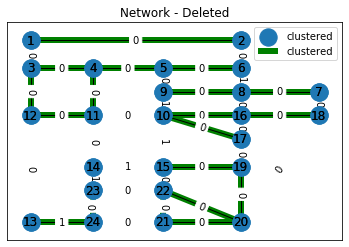

In [8]:
nx.draw_networkx(G_clustered, loc, width=6, edge_color='green', label='clustered')
nx.draw_networkx_edges(G, loc, edgelist=edgelist_deleted, width=6, edge_color='r', label='deleted-road')
nx.draw_networkx_edge_labels(G, loc, edge_labels=types)
nx.draw_networkx(G_clustered, loc)
plt.title('Network - Deleted')
plt.legend(loc='best')
plt.show()

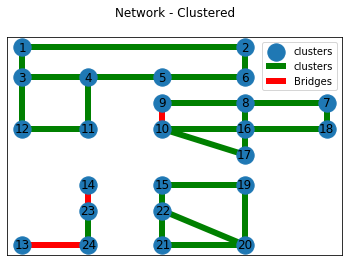

In [9]:
edgelist_type=list(G_clustered.edges(data='bridge'))
bridge= [(u, v) for (u, v, d) in edgelist_type if d == 1]
link_b = [(u, v) for (u, v, d) in G_clustered.edges(data=True) if d['bridge'] == 1]
link_c = [(u, v) for (u, v, d) in G_clustered.edges(data=True) if d['bridge'] == 0]


nx.draw_networkx(G_clustered, loc, width=6, edge_color='green', label='clusters')
nx.draw_networkx_edges(G, loc, edgelist=edgelist_deleted, width=1, edge_color='b', label='deleted')
nx.draw_networkx_edges(G_clustered, loc, edgelist=link_b, width=6, edge_color='r', label='Bridges')
#nx.draw_networkx_edges(G, loc, edgelist=edgelist_deleted, width=6, edge_color='r', label='deleted-road')
#nx.draw_networkx_edge_labels(G, loc, edge_labels=types)
plt.title('Network - Clustered\n')
plt.legend(loc='best')
plt.savefig('test2png1-a.png', dpi=500)
plt.show()

#### Issue:
Here the STEP 2 algorithm, fail to pull these 3 remaining brigdes out of the cluster. If we see the position of bridges in the cluster, we know that the position is bot in central, hence, Girvan-Newman could not detect it to break it to smaller cluster.

#### STEP 3 and 4 are done manually
The improvement to create a search algorithm to check and investigate each cluster pair is needed in future